# Feed Forward Neural Network #

In [1]:
import pandas as pd
import string
import os
import numpy as np
import urllib
import requests
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import roc_curve, auc, classification_report
from sklearn.preprocessing import label_binarize
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
import time
import glob
import seaborn as sns
import operator
import folium
from itertools import cycle, islice
from pandas import options
import warnings
import pickle
import re
import nltk
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
from matplotlib.pyplot import figure
from nltk.corpus import stopwords 
import nltk


nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Raunak\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Raunak\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# DATA_SET = './datasets/aclimdb.csv'
DATA_SET = './FinalDataset.csv'
df_ffnn =pd.read_csv(DATA_SET, index_col = 0)
df_ffnn

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1
...,...,...
990230,@LSDtweets put me down as a reference on that,1
138566,"shame about lucy gordon, killing herself, she ...",0
863540,"mmm I took an angelfood cake. cut it, put quin...",1
969307,has just arived in zagreb,1


## Preprocessing ##

## Data Cleaning ##

In [3]:
# Lowercasing and removing punctuations and symbols
df_ffnn['review'] = df_ffnn['review'].str.lower()

#Define function for removing special characters
def remove_special_characters(text, remove_digits=True):
    text=re.sub(r'[^a-zA-z0-9\s]','',text)
    return text

df_ffnn['review'] = df_ffnn['review'].apply(lambda x:''.join([i for i in x if i not in string.punctuation]))

#Apply function on review column
df_ffnn['review'] = df_ffnn['review'].apply(remove_special_characters)


df_ffnn

,review,sentiment
0,one of the other reviewers has mentioned that ...,1
1,a wonderful little production br br the filmin...,1
2,i thought this was a wonderful way to spend ti...,1
3,basically theres a family where a little boy j...,0
4,petter matteis love in the time of money is a ...,1
...,...,...
990230,lsdtweets put me down as a reference on that,1
138566,shame about lucy gordon killing herself she wa...,0
863540,mmm i took an angelfood cake cut it put quince...,1
969307,has just arived in zagreb,1


In [4]:
df_ffnn['sentiment'].value_counts()

0    73698
1    72062
Name: sentiment, dtype: int64

In [5]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
sentiment_label = le.fit_transform(df_ffnn["sentiment"])
print(le.classes_)
df_ffnn =df_ffnn.drop("sentiment",axis="columns")
df_ffnn["sentiment"] = sentiment_label
df_ffnn

[0 1]


,review,sentiment
0,one of the other reviewers has mentioned that ...,1
1,a wonderful little production br br the filmin...,1
2,i thought this was a wonderful way to spend ti...,1
3,basically theres a family where a little boy j...,0
4,petter matteis love in the time of money is a ...,1
...,...,...
990230,lsdtweets put me down as a reference on that,1
138566,shame about lucy gordon killing herself she wa...,0
863540,mmm i took an angelfood cake cut it put quince...,1
969307,has just arived in zagreb,1


In [6]:
df_ffnn['sentiment'].value_counts()

0    73698
1    72062
Name: sentiment, dtype: int64

In [7]:
import re
#Remove tags and links 
tag = re.compile(r'<[^>]+>')

df_ffnn['review'] = df_ffnn['review'].apply(lambda x: tag.sub('', x)) #removing html labels

df_ffnn['review'] = df_ffnn['review'].replace(r'http\S+', '', regex=True).replace(r'www.\S+', '', regex=True).replace(r'http\S+', '', regex=True).replace(r'"', '', regex=True)

df_ffnn

,review,sentiment
0,one of the other reviewers has mentioned that ...,1
1,a wonderful little production br br the filmin...,1
2,i thought this was a wonderful way to spend ti...,1
3,basically theres a family where a little boy j...,0
4,petter matteis love in the time of money is a ...,1
...,...,...
990230,lsdtweets put me down as a reference on that,1
138566,shame about lucy gordon killing herself she wa...,0
863540,mmm i took an angelfood cake cut it put quince...,1
969307,has just arived in zagreb,1


In [8]:
# Tokenization and Lemmanization

nltk.download('omw-1.4')

w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return " ".join([lemmatizer.lemmatize(w, pos="v") for w in w_tokenizer.tokenize(text)])

df_ffnn['review'] = df_ffnn.review.apply(lemmatize_text).copy()

df_ffnn

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Raunak\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


,review,sentiment
0,one of the other reviewers have mention that a...,1
1,a wonderful little production br br the film t...,1
2,i think this be a wonderful way to spend time ...,1
3,basically theres a family where a little boy j...,0
4,petter matteis love in the time of money be a ...,1
...,...,...
990230,lsdtweets put me down as a reference on that,1
138566,shame about lucy gordon kill herself she be in...,0
863540,mmm i take an angelfood cake cut it put quince...,1
969307,have just arived in zagreb,1


In [9]:
df_ffnn = df_ffnn.sample(50000)

x = pd.DataFrame(df_ffnn, columns = ['review']) 
y = pd.DataFrame(df_ffnn, columns = ['sentiment']) 

# Split dataset to train and test set.
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.25, random_state=42)

print("Shape of x_train: ", X_train.shape)
print("Shape of y_train: ", Y_train.shape)
print("Shape of x_test:  ", X_test.shape)
print("Shape of y_test:  ", Y_test.shape)


Shape of x_train:  (37500, 1)
Shape of y_train:  (37500, 1)
Shape of x_test:   (12500, 1)
Shape of y_test:   (12500, 1)


## Vectorization with TF-IDF ##

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

train = X_train['review'].tolist()
test = X_test['review'].tolist()
STOPWORDS = set(stopwords.words('english'))

tfidf_vectorizer = TfidfVectorizer(max_features=1000, dtype=np.float32)

tfidfX_train = tfidf_vectorizer.fit_transform(train)
tfidfX_train = tfidfX_train.toarray()

tfidfX_test = tfidf_vectorizer.transform(test)
tfidfX_test = tfidfX_test.toarray()

print("TF-IDF train shape:", tfidfX_train.shape)
print("TF-IDF test shape:", tfidfX_test.shape)

TF-IDF train shape: (37500, 1000)
TF-IDF test shape: (12500, 1000)


## Converting to Tensors ##

In [11]:
# Convert X datasets to tensors.
tfidfX_train = torch.tensor(tfidfX_train)
tfidfX_test = torch.tensor(tfidfX_test)

# Convert Y labels to tensors with torch.squeeze.
Y_train = torch.squeeze(torch.from_numpy(Y_train.to_numpy()).float())
Y_test = torch.squeeze(torch.from_numpy(Y_test.to_numpy()).float())

## Building the Model ##

In [12]:
# Use cuda if present
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device available for running: ")
print(device)

Device available for running: 
cpu


In [13]:
class FeedforwardNeuralNetModel(nn.Module):
    def __init__(self, input_dim, hidden_dim_1, hidden_dim_2, output_dim):
        super(FeedforwardNeuralNetModel, self).__init__()
        
        # Linear function 1
        self.layer_1 = nn.Linear(input_dim, hidden_dim_1) 
        # self.dropout = nn.Dropout(0.3)
        # self.batch1 = nn.BatchNorm1d(hidden_dim)
        
        # Non-linearity 1
        self.relu_1 = nn.ReLU()

        # Linear function 2
        self.layer_2 = nn.Linear(hidden_dim_1, hidden_dim_2)
        # Non-linearity 2
        self.relu_2 = nn.ReLU()

        # Linear function 3
        self.layer_3 = nn.Linear(hidden_dim_2, output_dim)  

    def forward(self, x):
        out = self.layer_1(x)
        out = self.relu_1(out)

        out = self.layer_2(out)
        out = self.relu_2(out)

        out = self.layer_3(out)

        return torch.sigmoid(out)

## Initializing the Model ##

In [14]:
# Dimensions of each layer and num of epochs.
input_dim = tfidfX_train.shape[1]
hidden_dim_1 = 512
hidden_dim_2 = 512
output_dim = 1
num_epochs = 600

# Define our first feed forward neural network.
first_model = FeedforwardNeuralNetModel(input_dim,hidden_dim_1,hidden_dim_2,output_dim)

# Define loss function.
criterion = nn.BCELoss()
# criterion = nn.CrossEntropyLoss()

# Define as optimizer Adam.
optimizer = optim.Adam(first_model.parameters(),lr=0.1e-3,weight_decay=1e-3)

# Transfer all the computation to GPU (cuda device).
first_model.to(device)
criterion = criterion.to(device)


## Training the Model ##

In [15]:
# This is a function that calculate the accuracy manually
def calculate_accuracy(y_true, y_pred):  
    y_pred = torch.round(y_pred)
    correct = (y_true == y_pred).float() 
    acc = correct.sum() / len(correct)
    return acc

batch_size = 10000

# Split train dataset to mini batches
X_train_mini_batches = torch.split(tfidfX_train,batch_size)
Y_train_mini_batches = torch.split(Y_train,batch_size)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Start training
for epoch in range(num_epochs):
    epoch_loss = 0
    epoch_accuracy = 0
    validation_loss=0
    val_accuracy=0
    
    for X_train_mini_batch,Y_train_mini_batch in zip(X_train_mini_batches,Y_train_mini_batches):
        
        X_train_mini_batch = X_train_mini_batch.to(device)
        Y_train_mini_batch = Y_train_mini_batch.to(device)
        
        # Forward pass to get output
        train_prediction = first_model.forward(X_train_mini_batch.float())
        train_prediction = torch.squeeze(train_prediction)

        # Calculate Loss
        train_loss = criterion(train_prediction,Y_train_mini_batch)

        # Clearing up accumulated gradients
        optimizer.zero_grad()
    
        # Getting gradients
        train_loss.backward()

        # Updating parameters
        optimizer.step()

        # Add each mini batch's loss
        epoch_loss += train_loss.item()

        # Add each mini batch's accuracy
        epoch_accuracy += calculate_accuracy(Y_train_mini_batch,train_prediction)
        
    # For some epochs print loss and accucary of train and validation set.
    
    if epoch % 1 == 0:
        

        epoch_loss /= len(X_train_mini_batches)
        epoch_accuracy /= len(X_train_mini_batches)
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)
        #print("Epoch:",epoch, "\n"
         #      "Train_loss:",round(epoch_loss,4), "Train Accuracy:",round(epoch_accuracy.item(),4))

In [16]:
# Calculating Accuracy

tfidfX_test = tfidfX_test.to(device)
Y_test = Y_test.to(device)

# Forward pass to get output
test_prediction = first_model.forward(tfidfX_test.float())
test_prediction = torch.squeeze(test_prediction)

#Calculate accuracy on test set
test_accuracy = calculate_accuracy(Y_test,test_prediction)

print("Accuracy:",round(test_accuracy.item(),4)*100)

Accuracy: 80.4


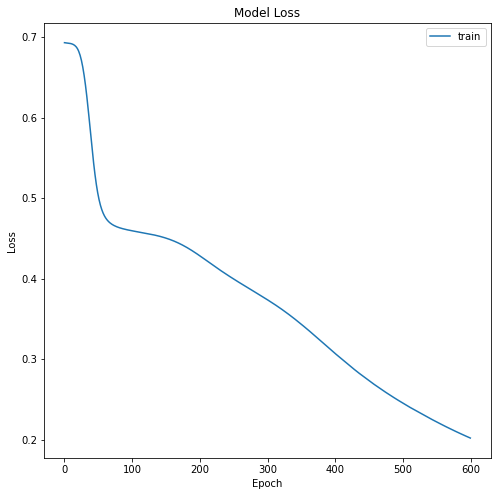

In [17]:
# Plotting loss vs epochs
import seaborn as sns
import matplotlib.pyplot as plt

figure(figsize=(8,8)) 
plt.plot(train_losses)
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train'], loc='upper right')
plt.show()

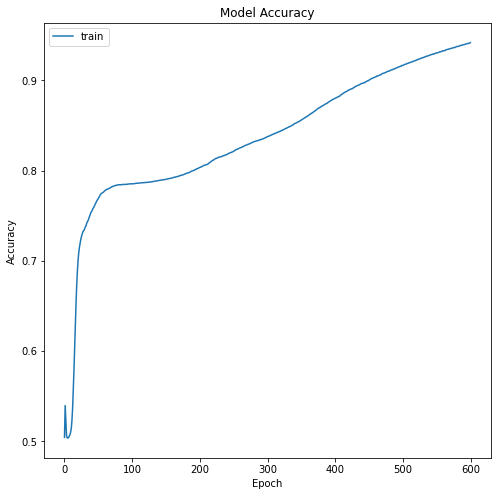

In [18]:
# Plotting accuracy vs epochs
figure(figsize=(8,8)) 
plt.plot(train_accuracies)
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [19]:
# Classification report
test_prediction = test_prediction.to(device)
test_prediction = test_prediction.ge(.5).view(-1).cpu()
Y_test = Y_test.cpu()

print(classification_report(Y_test,test_prediction))

              precision    recall  f1-score   support

         0.0       0.81      0.80      0.81      6372
         1.0       0.80      0.80      0.80      6128

    accuracy                           0.80     12500
   macro avg       0.80      0.80      0.80     12500
weighted avg       0.80      0.80      0.80     12500



In [24]:
# Classification report
train_prediction = train_prediction.to(device)
train_prediction = train_prediction.ge(.5).view(-1).cpu()
Y_train_mini_batch = Y_train_mini_batch.cpu()

print(classification_report(Y_train_mini_batch,train_prediction))

              precision    recall  f1-score   support

         0.0       0.97      0.95      0.96      3798
         1.0       0.95      0.97      0.96      3702

    accuracy                           0.96      7500
   macro avg       0.96      0.96      0.96      7500
weighted avg       0.96      0.96      0.96      7500

